# Fine-tuning DETR on TACO (and another detect-waste datasets)

Credits:
- [Sylwia Majchrowska](https://github.com/majsylw)

Adapted from:
-   https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb
-   https://github.com/woctezuma/finetune-detr

Parameters:
- Official DETR repository: https://github.com/facebookresearch/detr
- Optimizer: AdamW or LaProp
- Number of class:
  - 6 (paper, metals and plastics, bio, other, non-recycle, glass) [for 1.5k TACO only],
  - 7 (paper, metals and plastics, bio, other, non-recycle, glass, unknown),
  - or 1 (litter).
- Backbone: ResNet50, ResNet101
- Num queries: 100 (like in official Detr it coressponds to max number of instances per images - this should not be changed if we finetuned)
- Eos coef: 0.1 (like in official Detr mean number of instances per image - this should not be changed if we finetuned)
- 300 epochs at lr 1e-4 with lr_drop to 1e-5 at 100

## Datasets

1. [Taco](http://tacodataset.org/)
  - Relatively small with ~1k Train, 150 validation images
  - We additionaly add ~3.5k images with bbox annotations
  - To contrast The COCO dataset is an excellent object detection dataset with 80 classes, 80,000 training images and 40,000 validation images
2. Multi - mixed few object detection/segmentation waste datasets mentioned in main ```README.md```
  - 19798 training, 4940 validation images from about 7 waste dataset from different enviroments (1 class)

### 1.1 Prepare coco annotations:
- 1 class - litter,
- 6 classes - paper, metals and plastics, bio, other, non-recycle, glass
- 7 classes - paper, metals and plastics, bio, other, non-recycle, glass, unknown.

Can be found at `annotations` directory (check its ```README``` file).

### 1.2 Download all images
- all links to waste datasets used in this projet are provieded in main ```README.md```.

In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
from shutil import copyfile
import os
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [2]:
annFile='../../annotations/annotations_test.json' # path to example annotations
dataDir = '/dih4/dih4_2/wimlds/data/all_detect_images' # path to your directory with images - TO CHANGE

In [3]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [4]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(', '.join(nms)))

COCO categories: 
metals_and_plastic, other, non_recyclable, glass, paper, bio, unknown



Image n°4445
Image name: /dih4/dih4_2/wimlds/data/all_detect_images/dumped/sdQ1FMkHRi5LTeXvngMLDyWqZpcAYlIrw26CRnjm.jpeg


(-0.5, 4031.5, 3023.5, -0.5)

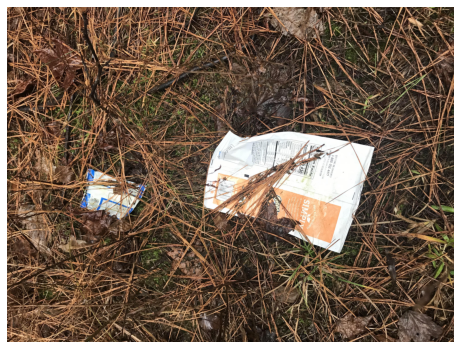

In [5]:
# load and display image
catIds = coco.getCatIds(catNms=['non recyclable'])
imgIds = coco.getImgIds(catIds=catIds)
img_id = imgIds[np.random.randint(0,len(imgIds))]
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s'%(dataDir, img['file_name'])
print('Image name: {}'.format(img_name))

I = io.imread(img_name)
plt.figure()
plt.imshow(I)
plt.axis('off')

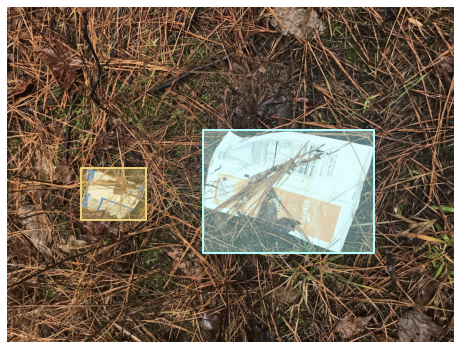

In [6]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)

## Training

Please just follow notes described in readme file tu run script ``main.py`` with parameters from command line.

For example:
```python3 main.py --coco_path /path/to/images --dataset_file taco --num_classes 1 --output_dir taco_1 --resume detr-r50-e632da11.pth```

All checkpoints to resume can be downloaded from [official repository](https://github.com/facebookresearch/detr).


### 2.1 Train chosen model with parameters:
- from sctrach with 1 or 7 classes
- fine tuned model detr50 with 1 or 7 classes and with AdamW and LaProp Optimizer: https://github.com/facebookresearch/detr/issues/9 (set ```dataset_file``` as ```taco``` or ```multi```)

### 2.1 Things changed:
- the parameter name ```num_classes``` is misleading. It is actually the ID which DETR will reserve for its own no_object class. It should be set to one plus the highest class ID in your dataset. It has to be changed in ```models/detr.py``` in 314 line. We provided argparse argument ```--num_classes```, and put the value ```args.num_classes + 1``` there;
- dataset to load: create functions ```build_taco()```, and ```build_multi()``` with parameters in ```datasets/coco.py``` lines 147-192 and modify function build_dataset in ```datasets/__init__.py``` in lines 19-30;
- delete head of source model to enable classyfication of proper number of class in ```main.py```: lines 223 - 228;
- add new optimizer ```LaProp class``` in util directory - to choose just type ```--optimizer LaProp``` while running a script.

## Testing

Using ```plot_utils.py``` script one can evaluate results - plot loss, mAP ect.

In [7]:
# training from sctrach
import sys
sys.path.append('../')

from util.plot_utils import *
from pathlib import Path, PurePath

In [8]:
fields = ('loss','class_error','loss_bbox','loss_giou','mAP')  # <-- I put the items of interest here

### 3.1 Training from sctrach on TACO (1.5k images)

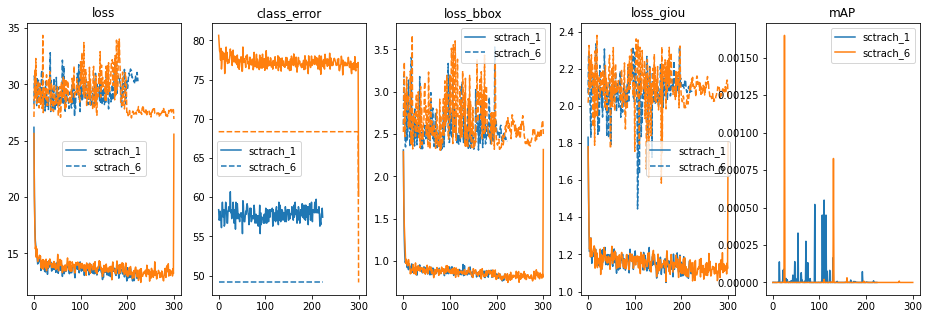

In [9]:
plot_logs([Path('/dih4/dih4_2/wimlds/smajchrowska/detr/sctrach_1'), Path('/dih4/dih4_2/wimlds/smajchrowska/detr/sctrach_6')], fields, save=False)

### 3.2 Fine tuned model on TACO (1.5k images)

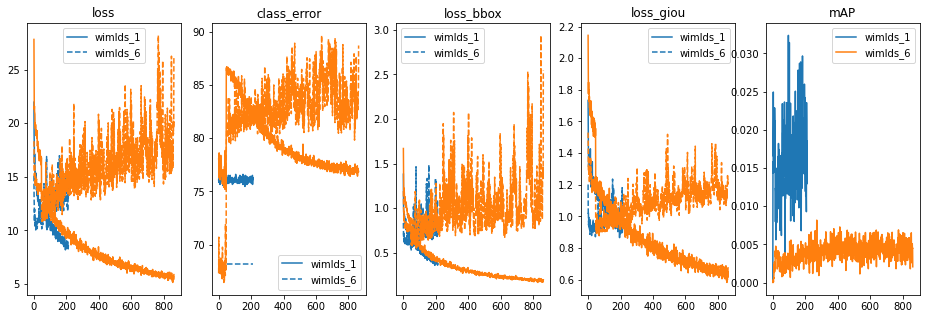

In [10]:
# finetuning first attempt: 1 or 6 classes with ResNet50 and AdamW
plot_logs([Path('/dih4/dih4_2/wimlds/smajchrowska/detr/wimlds_1'), Path('/dih4/dih4_2/wimlds/smajchrowska/detr/wimlds_6')], fields, save=False)

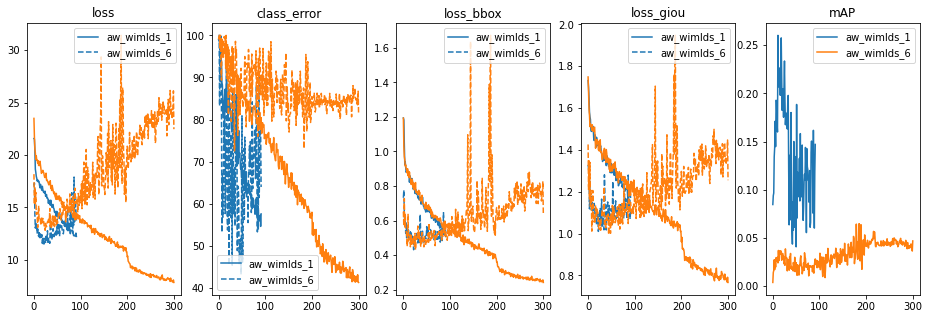

In [11]:
# finetuning second attempt: 1 or 6 classes with ResNet50 and AdamW
plot_logs([Path('/dih4/dih4_2/wimlds/smajchrowska/detr/aw_wimlds_1'), Path('/dih4/dih4_2/wimlds/smajchrowska/detr/aw_wimlds_6')], fields, save=False)

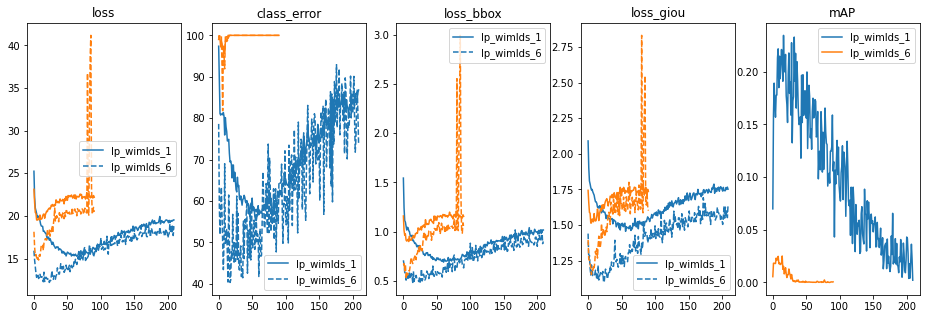

In [12]:
# finetuning third attempt: 1 or 6 classes with ResNet50 and LaProp
plot_logs([Path('/dih4/dih4_2/wimlds/smajchrowska/detr/lp_wimlds_1'), Path('/dih4/dih4_2/wimlds/smajchrowska/detr/lp_wimlds_6')], fields, save=False)

### 3.3 Fine tuned model on extended TACO

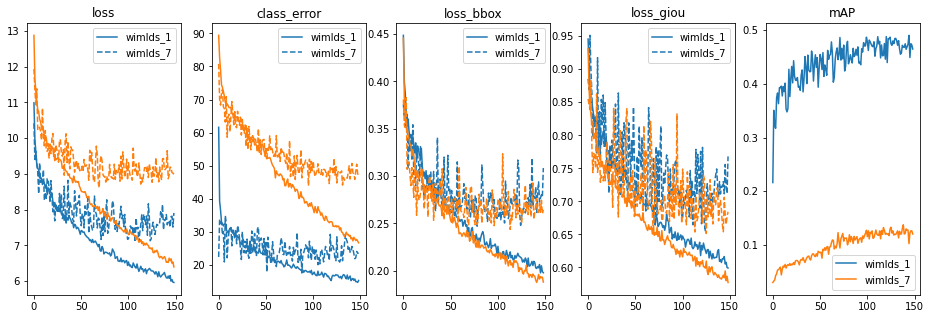

In [13]:
# finetuning fourth attempt: 1 or 7 classes with ResNet50
plot_logs([Path('/dih4/dih4_2/wimlds/smajchrowska/wimlds_1'), Path('/dih4/dih4_2/wimlds/smajchrowska/wimlds_7')], fields, save=False)

### 3.4 Fine tuned model on multi datasets

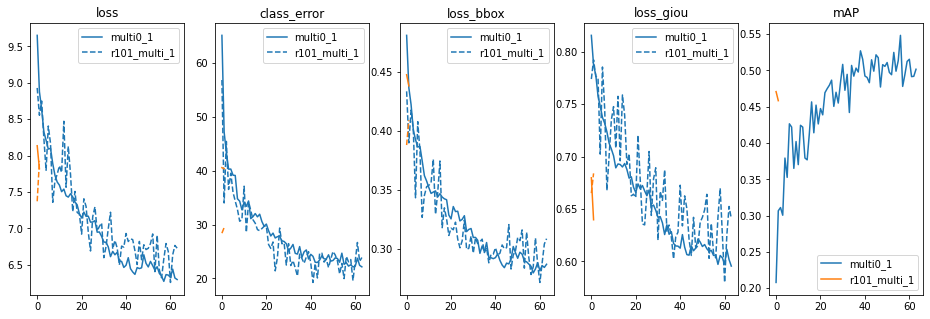

In [14]:
# finetuning fourth attempt: 1 class with ResNet50 and ResNet101
plot_logs([Path('/home/smajchrowska/detect-waste/detr/multi0_1'), Path('/dih4/dih4_2/wimlds/smajchrowska/r101_multi_1')], fields, save=False)

### 3.5 Fine tuned model on multi datasets with frozen weights for instance segmentation

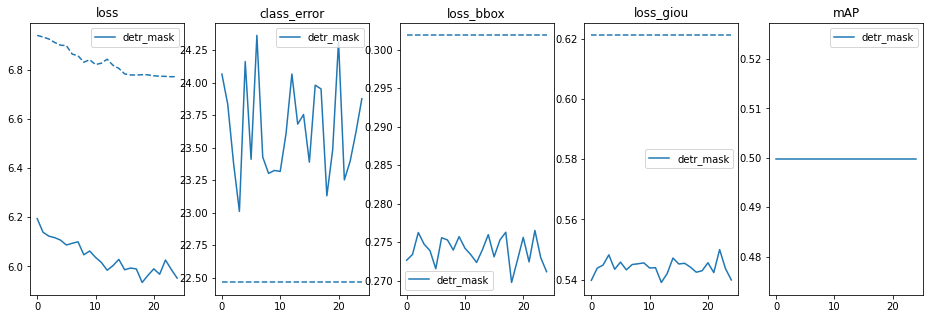

In [15]:
# finetuning fourth attempt: 1 class with ResNet50 and ResNet101
plot_logs([Path('/dih4/dih4_2/wimlds/smajchrowska/detr_mask')], fields, save=False)

#### Understand the logs
From the log, we can have a basic understanding the training process and know how well the detector is trained.

Firstly, the ResNet-50 (or ResNet-101) backbone pre-trained on ImageNet is loaded, this is a common practice since training from scratch is more cost - too long, and not effective enough.

Second, since the dataset we are using is small, we loaded a pretrained Detr model and finetune it for detection our classes. The original Mask R-CNN is trained on COCO dataset which contains 80 classes but in our variation about waste datasets only have 1 class. Therefore, the few last layers (```class_embed.weight```, ```class_embed.bias```, ```query_embed.weight```) of the pre-trained DETR for classification has different weight shape and is not used.

Third, after training, the detector is evaluated by the default VOC-style (`mAP@0.5`) evaluation. The results show that the detector achieves ~50.6 mAP on the val dataset for multi bbox one class, not bad!

### 3.3 Check results...

In [16]:
from demo_image import plot_results, get_transforms, rescale_bboxes, set_model

chtype = 'MULTI_BBox'
img_name = 'http://media.pixcove.com/V/9/9/Bottle-Flask-Landscapes-Nature-Glass-Bottles-Dispo-8171.jpg'
threshold = 0.59

if chtype == 'TACO_6':
    # TACO2detect_waste classes
    CLASSES = [
        'Glass', 'Metals and plastics', 'Non recyclable', 'Other', 'Paper', 'Bio'
    ]
    chpath = '/dih4/dih4_2/wimlds/smajchrowska/detr/aw_wimlds_6/checkpoint.pth'
    model_name = 'detr_resnet50'
elif chtype == 'TACO_7':
    CLASSES = [
        'Metals and plastics', 'Other', 'Non recyclable', 'Glass', 'Paper', 'Bio', 'Unknown'
    ]
    chpath = '/dih4/dih4_2/wimlds/smajchrowska/wimlds_7/checkpoint.pth'
    model_name = 'detr_resnet50'
elif chtype == 'TACO_1':
    CLASSES = [
        'Litter'
    ]
    chpath = '/dih4/dih4_2/wimlds/smajchrowska/wimlds_1/checkpoint.pth'
    model_name = 'detr_resnet50'
elif chtype == 'MULTI_BBox':
    CLASSES = [
        'Litter'
    ]
    chpath = '/home/smajchrowska/detect-waste/detr/multi0_1/checkpoint.pth'
    model_name = 'detr_resnet50'
elif chtype == 'MULTI_Mask':
    CLASSES = [
        'Litter'
    ]
    chpath = f'/dih4/dih4_2/wimlds/smajchrowska/detr_mask/checkpoint.pth'
    model_name = 'detr_resnet101_panoptic'

In [17]:
torch.set_grad_enabled(False)
num_classes = len(CLASSES)
print(num_classes)
model = set_model(model_name, num_classes, chpath, 'cpu')
model.eval()

1


Using cache found in /home/smajchrowska/.cache/torch/hub/facebookresearch_detr_master


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Drop

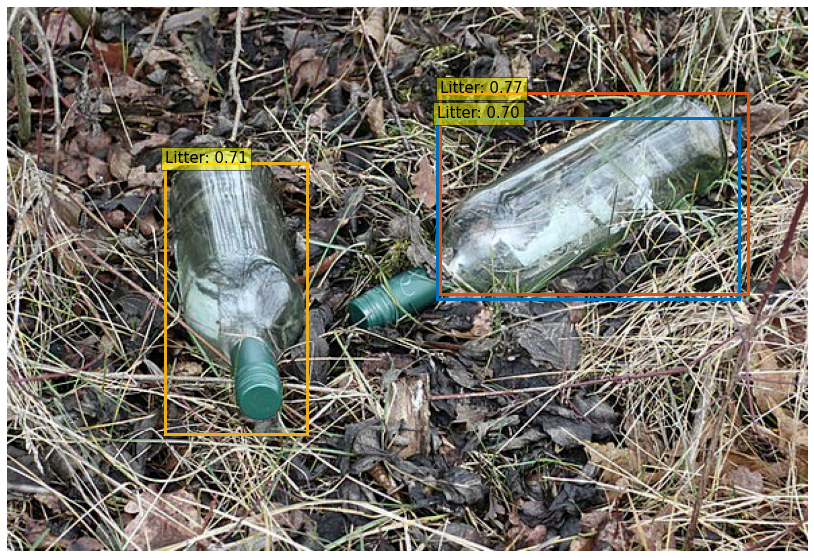

In [18]:
from PIL import Image
import requests

# get image
if img_name.startswith('http'):
    im = Image.open(requests.get(img_name, stream=True).raw).convert('RGB')
else:
    im = Image.open(img_name).convert('RGB')


# mean-std normalize the input image (batch-size: 1)
img = get_transforms(im)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.x+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > threshold

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

# plot results
plot_results(im, probas[keep], bboxes_scaled, CLASSES)

In [19]:
import math

if chtype == 'MULTI_Mask':
    # Plot all the remaining masks
    ncols = 3
    fig, axs = plt.subplots(ncols=ncols, nrows=math.ceil(keep.sum().item() / ncols), figsize=(18, 10))
    #for line in axs:
    #    for a in line:
    #        a.axis('off')
    for i, mask in enumerate(outputs["pred_masks"][0, keep]):
        ax = axs[i // ncols, i % ncols]
        ax.imshow(mask, cmap="cividis")
        ax.axis('off')
    fig.tight_layout()